# **Import các thư viện cần thiết**

In [ ]:
import pandas as pd
import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix, classification_report, confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, scale
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours
from itertools import cycle
import joblib
import pickle
# Ẩn các warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CTU-13**

# **Đọc bộ dữ liệu CTU-13 từ Drive**

In [ ]:
# Dùng đường dẫn đến file CTU_13.csv
df_CTU_13 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CTU_13.csv', index_col=0)

In [ ]:
df_CTU_13

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,2011/08/10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,2011/08/10 09:47:48.185538,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,2011/08/10 09:47:48.230897,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,2011/08/10 09:47:48.963351,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19976695,2011/08/16 09:36:00.710103,0.000000,udp,147.32.84.229,13363,->,125.14.162.10,27460,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976696,2011/08/16 09:36:00.777160,0.000427,udp,213.146.167.54,20856,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976697,2011/08/16 09:36:00.784094,0.000000,udp,147.32.84.229,13363,->,122.121.0.92,12923,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976698,2011/08/16 09:36:00.784160,0.000000,udp,147.32.84.229,13363,->,110.233.175.133,37690,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt


Số lượng các giá trị bị thiếu trong các cột/ tính năng

In [ ]:
df_CTU_13.isnull().sum()

StartTime          0
Dur                0
Proto              0
SrcAddr            0
Sport         203075
Dir                0
DstAddr            0
Dport         194048
State           1378
sTos          220518
dTos         1717996
TotPkts            0
TotBytes           0
SrcBytes           0
Label              0
dtype: int64

# **Xoá các cột ‘StartTime’, ‘SrcAddr’, ‘Sport’, ‘DstAddr’, ‘Dport’, ‘State’**

In [ ]:
df_CTU_13 = df_CTU_13.drop(['StartTime','SrcAddr','Sport','DstAddr','Dport','State'], axis=1)
df_CTU_13

,Dur,Proto,Dir,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,tcp,->,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,1.009595,tcp,->,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,3.056586,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,3.111769,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,3.083411,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...
19976695,0.000000,udp,->,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976696,0.000427,udp,<->,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976697,0.000000,udp,->,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976698,0.000000,udp,->,0.0,NaN,1,476,476,flow=Background-UDP-Attempt


# **1. Xử lý các giá trị NaN**

In [ ]:
# Thay thế các giá trị NaN bằng số 9
df_CTU_13 = df_CTU_13.fillna(9)
df_CTU_13

,Dur,Proto,Dir,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,tcp,->,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,1.009595,tcp,->,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,3.056586,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,3.111769,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,3.083411,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...
19976695,0.000000,udp,->,0.0,9.0,1,476,476,flow=Background-UDP-Attempt
19976696,0.000427,udp,<->,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976697,0.000000,udp,->,0.0,9.0,1,476,476,flow=Background-UDP-Attempt
19976698,0.000000,udp,->,0.0,9.0,1,476,476,flow=Background-UDP-Attempt


In [ ]:
df_CTU_13.isnull().sum()

Dur         0
Proto       0
Dir         0
sTos        0
dTos        0
TotPkts     0
TotBytes    0
SrcBytes    0
Label       0
dtype: int64

# **Gán lại nhãn mới cho cột Label**

*  Background traffic là 0
* Botnet traffic (DDoS traffic) là 1
*  Normal traffic là 2


In [ ]:
lst = []
for i in df_CTU_13['Label']:
    if 'Botnet' in i:
        lst.append(1)
    elif 'Normal' in i:
        lst.append(2)
    else:
        lst.append(0)

df_CTU_13['Label'] = lst
df_CTU_13

,Dur,Proto,Dir,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,tcp,->,0.0,0.0,4,276,156,0
1,1.009595,tcp,->,0.0,0.0,4,276,156,0
2,3.056586,tcp,->,0.0,0.0,3,182,122,0
3,3.111769,tcp,->,0.0,0.0,3,182,122,0
4,3.083411,tcp,->,0.0,0.0,3,182,122,0
...,...,...,...,...,...,...,...,...,...
19976695,0.000000,udp,->,0.0,9.0,1,476,476,0
19976696,0.000427,udp,<->,0.0,0.0,2,135,75,0
19976697,0.000000,udp,->,0.0,9.0,1,476,476,0
19976698,0.000000,udp,->,0.0,9.0,1,476,476,0


In [ ]:
df_CTU_13['Label'].value_counts()

0    19175551
1      444699
2      356433
Name: Label, dtype: int64

# **2.1. Mã hoá với giá trị số**

Gán giá trị số cho các giá trị trong cột 'Proto'

In [ ]:
# udp = 17, tcp = 6, icmp = 1, other = 0
protocol_number = []
for i in df_CTU_13['Proto']:
    if i == 'udp':
        protocol_number.append(17)
    elif i == 'tcp':
        protocol_number.append(6)
    elif i == 'icmp':
        protocol_number.append(1)
    else:
        protocol_number.append(0)

df_CTU_13['Proto'] = protocol_number
df_CTU_13

Gán giá trị số cho các giá trị trong cột 'Dir'

In [ ]:
# '  <->' = 1, '   ->' = 2, other = 0
direction_number = []
for i in df_CTU_13['Dir']:
    if i == '  <->':
        direction_number.append(1)
    elif i == '   ->':
        direction_number.append(2)
    else:
        direction_number.append(0)

df_CTU_13['Dir'] = direction_number
df_CTU_13

In [ ]:
A = df_CTU_13.copy()

# **2.2. Mã hoá One-Hot Encoding**

In [ ]:
A = df_CTU_13.copy()

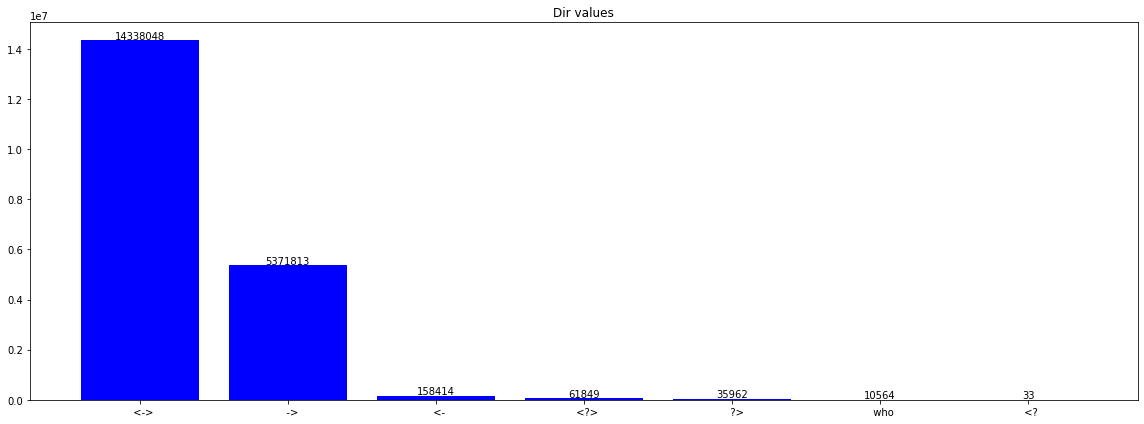

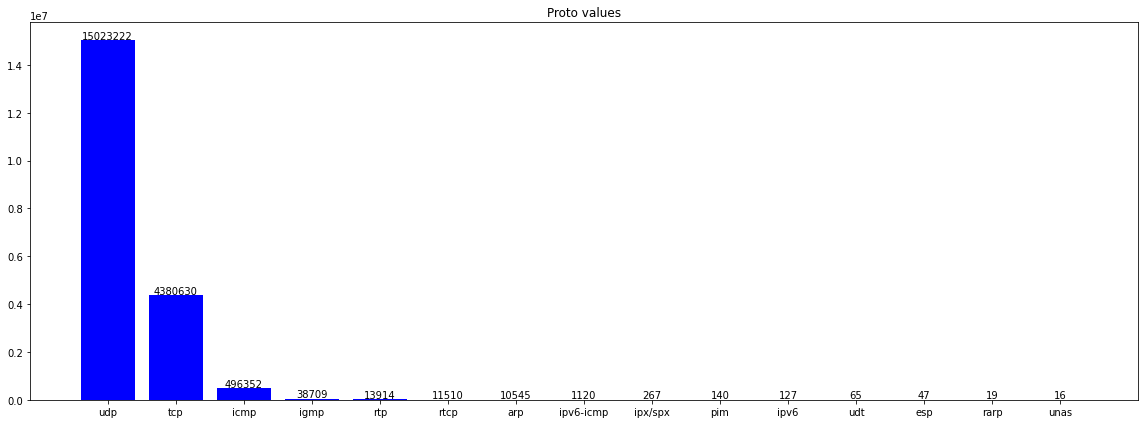

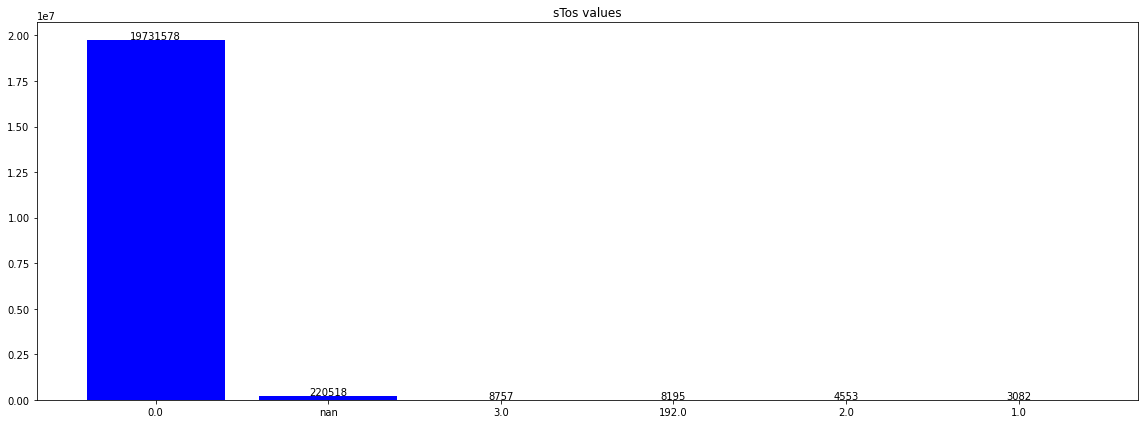

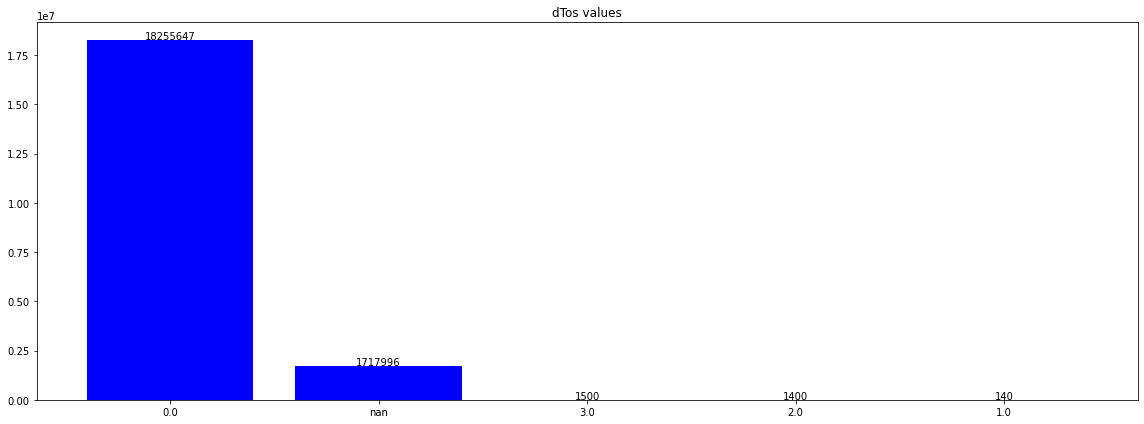

In [ ]:
def draw_plot(col):
    if col.name == 'sTos' or col.name == 'dTos':
        col = col.astype('str')
    names = col.value_counts().index.tolist()
    values = col.value_counts().tolist()
    fig, ax = plt.subplots(figsize =(16, 6)) 
    ax.bar(names, values, color='Blue')
    plot_name = col.name + ' values'
    ax.set_title(plot_name)
    for index, data in enumerate(values):
        plt.text(x=index, y=data+50000, s=f"{data}", fontdict=dict(fontsize=10), horizontalalignment='center')  
    plt.tight_layout()
    plt.show()

one_hot_lst = ['Dir','Proto','sTos','dTos']
for i in one_hot_lst:
    draw_plot(A[i])

In [ ]:
one_hot_lst = ['Dir','Proto','sTos','dTos']
column_list = ['Dur','TotPkts','TotBytes','SrcBytes',
               'Dir_   ->','Dir_  <->','Dir_others',
	             'Proto_icmp','Proto_tcp','Proto_udp','Proto_others',
               'sTos_0.0','sTos_9.0','sTos_others','dTos_0.0','dTos_9.0','dTos_others','Label']

def one_hot_encoding(df):
    df_new = pd.DataFrame()
    other_list = []
    for i in one_hot_lst:
        if i == 'Dir':
            for j in df[i]:
                if j == '  <->' or j == '   ->':
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'Dir_others'
            df[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df, columns=[i])
        elif i == 'Proto':
            for j in df[i]:
                if j == 'tcp' or j == 'udp' or j == 'icmp':
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'Proto_others'
            df_new[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df_new, columns=[i])
        elif i == 'sTos':
            for j in df[i]:
                if j == 0 or j == 9:
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'sTos_others'
            df_new[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df_new, columns=[i])
        elif i == 'dTos':
            for j in df[i]:
                if j == 0 or j == 9:
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'dTos_others'
            df_new[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df_new, columns=[i])
    for col in df_new.columns:
        if col not in column_list:
            df_new = df_new.drop([col], axis=1)
    return df_new

A = one_hot_encoding(A)
A

,Dur,TotPkts,TotBytes,SrcBytes,Label,Dir_others,Dir_ ->,Dir_ <->,Proto_others,Proto_icmp,Proto_tcp,Proto_udp,sTos_others,sTos_0.0,sTos_9.0,dTos_others,dTos_0.0,dTos_9.0
0,1.026539,4,276,156,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,1.009595,4,276,156,0,0,1,0,0,0,1,0,0,1,0,0,1,0
2,3.056586,3,182,122,0,0,1,0,0,0,1,0,0,1,0,0,1,0
3,3.111769,3,182,122,0,0,1,0,0,0,1,0,0,1,0,0,1,0
4,3.083411,3,182,122,0,0,1,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19976695,0.000000,1,476,476,0,0,1,0,0,0,0,1,0,1,0,0,0,1
19976696,0.000427,2,135,75,0,0,0,1,0,0,0,1,0,1,0,0,1,0
19976697,0.000000,1,476,476,0,0,1,0,0,0,0,1,0,1,0,0,0,1
19976698,0.000000,1,476,476,0,0,1,0,0,0,0,1,0,1,0,0,0,1


In [ ]:
# Tách thành tập X và y
X = A.drop(['Label'], axis=1).copy()
y = A['Label'].copy()

# **3.1. Chi-Squared**

In [ ]:
X_new = SelectKBest(chi2, k=10).fit_transform(X, y)
print(X_new.shape)
X_new

(19976683, 10)


array([[1.026539e+00, 4.000000e+00, 2.760000e+02, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.009595e+00, 4.000000e+00, 2.760000e+02, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.056586e+00, 3.000000e+00, 1.820000e+02, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 1.000000e+00, 4.760000e+02, ..., 0.000000e+00,
        1.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00, 4.760000e+02, ..., 0.000000e+00,
        1.000000e+00, 1.000000e+00],
       [8.000000e-06, 2.000000e+00, 1.400000e+02, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00]])

In [ ]:
X_new_df = pd.DataFrame(X_new)
X_new_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07
mean,2.879466e+02,4.139078e+01,3.232714e+04,6.435327e+03,2.689042e-01,7.177392e-01,2.484657e-02,2.192872e-01,7.520379e-01,8.600006e-02
std,8.318068e+02,5.545727e+03,3.983039e+06,1.667901e+06,4.433900e-01,4.500996e-01,1.556574e-01,4.137636e-01,4.318297e-01,2.803641e-01
min,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.750000e-04,2.000000e+00,2.140000e+02,7.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,7.270000e-04,2.000000e+00,2.640000e+02,8.300000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.966016e+00,4.000000e+00,6.190000e+02,3.040000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,3.657061e+03,1.658064e+07,4.376239e+09,3.423408e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


So sánh bảng X_new_df.describe() với bảng X.describe(). Ta biết được 10 cột được giữ lại là:

'Dur', 'TotPkts', 'TotBytes', 'SrcBytes', 'Dir_1', 'Dir_2', 'Proto_icmp', 'Proto_tcp', 'Proto_udp', 'dTos_9.0'

# **3.2. ANOVA**

In [ ]:
X_new = SelectKBest(f_classif, k=10).fit_transform(X, y)
print(X_new.shape)
X_new

(19976683, 10)


array([[1.026539e+00, 0.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.009595e+00, 0.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 0.000000e+00],
       [3.056586e+00, 0.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [8.000000e-06, 0.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00]])

In [ ]:
X_new_df = pd.DataFrame(X_new)
X_new_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07
mean,2.879466e+02,1.335667e-02,2.689042e-01,7.177392e-01,2.484657e-02,2.192872e-01,7.520379e-01,9.877304e-01,9.138478e-01,8.600006e-02
std,8.318068e+02,1.147967e-01,4.433900e-01,4.500996e-01,1.556574e-01,4.137636e-01,4.318297e-01,1.100864e-01,2.805887e-01,2.803641e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.750000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,7.270000e-04,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,1.966016e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,3.657061e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


So sánh bảng X_new_df.describe() với bảng X.describe(). Ta biết được 10 cột được giữ lại là:

'Dur', 'Dir_others', 'Dir_1', 'Dir_2', 'Proto_icmp', 'Proto_tcp', 'Proto_udp', 'sTos_0.0', 'dTos_0.0', 'dTos_9.0'

# **4.1. UnderSampling với RandomUnderSampler**

In [ ]:
rus = RandomUnderSampler(random_state=0, sampling_strategy={0: 801132, 1: 444699, 2: 356433})
X_res, y_res = rus.fit_resample(X_new_df, y)

In [ ]:
y_res.value_counts()

0    801132
1    444699
2    356433
Name: Label, dtype: int64

In [ ]:
X_res

,0,1,2,3,4,5,6,7,8,9
0,0.000271,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.000223,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.000242,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.000246,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.000366,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1602259,0.000145,2.0,233.0,74.0,0.0,1.0,0.0,0.0,1.0,0.0
1602260,0.000229,2.0,244.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
1602261,0.000357,2.0,400.0,74.0,0.0,1.0,0.0,0.0,1.0,0.0
1602262,18.002481,6.0,412.0,272.0,1.0,0.0,0.0,1.0,0.0,0.0


# **4.2. UnderSampling với NearMiss**

NearMiss version 1

In [ ]:
nearmiss = NearMiss(version=1, sampling_strategy={0: 801132, 1: 444699, 2: 356433})
X_res, y_res = nearmiss.fit_resample(X_new_df, y)

In [ ]:
y_res.value_counts()

0    801132
1    444699
2    356433
Name: Label, dtype: int64

In [ ]:
X_res

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1.0,74.0,74.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.000000,1.0,135.0,135.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,1.0,135.0,135.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,1.0,145.0,145.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.000000,1.0,156.0,156.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1602259,2343.518311,32743.0,28731392.0,27871226.0,0.0,0.0,0.0,1.0,0.0,0.0
1602260,1331.276367,64778.0,84571124.0,84023978.0,0.0,0.0,0.0,1.0,0.0,0.0
1602261,1805.375000,104956.0,137416417.0,136546777.0,0.0,0.0,0.0,1.0,0.0,0.0
1602262,3268.395996,212578.0,250218422.0,3039208.0,1.0,0.0,0.0,1.0,0.0,0.0


# **Tách X_train, X_test, y_train, y_test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
y_test.value_counts()

0    160263
1     89045
2     71145
Name: Label, dtype: int64

# **5.1. Normalization**

In [ ]:
# fit scaler on training data
scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train)

# transform training data
X_train = scaler.transform(X_train)

# transform testing dataabs
X_test = scaler.transform(X_test)

# **5.2. Standardization**

In [ ]:
# fit scaler on training data
scaler = StandardScaler().fit(X_train)

# transform training data
X_train = scaler.transform(X_train)

# transform testing dataabs
X_test = scaler.transform(X_test)

# **Decision Tree**

In [ ]:
model_DT = DecisionTreeClassifier(random_state=0)
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
y_predict_DT = model_DT.predict(X_test)
acc_score_DT = accuracy_score(y_test, y_predict_DT)
print("Accuracy score: {} %".format(acc_score_DT*100))
print(confusion_matrix(y_test, y_predict_DT))
bot_recall_score = recall_score(y_test, y_predict_DT, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_DT, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_DT, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 90.72812549734283 %
[[147292   4785   8186]
 [  4129  82819   2097]
 [  8511   2004  60630]]
Botnet traffic recall score: 0.9300802964793082
Botnet traffic precision score: 0.9242366752968485
Botnet traffic f1 score: 0.9271492782097138


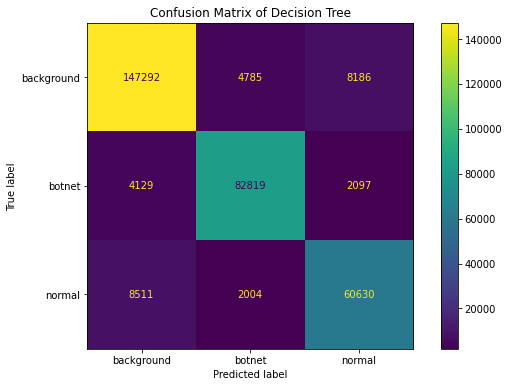

In [ ]:
matrix = plot_confusion_matrix(model_DT, X_test, y_test, display_labels=['background','botnet','normal'], values_format='d')
matrix.ax_.set_title('Confusion Matrix of Decision Tree')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
dt_pros = model_DT.predict_proba(X_test)
dt_pros

array([[1.        , 0.        , 0.        ],
       [0.94642857, 0.        , 0.05357143],
       [0.        , 1.        , 0.        ],
       ...,
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ]])

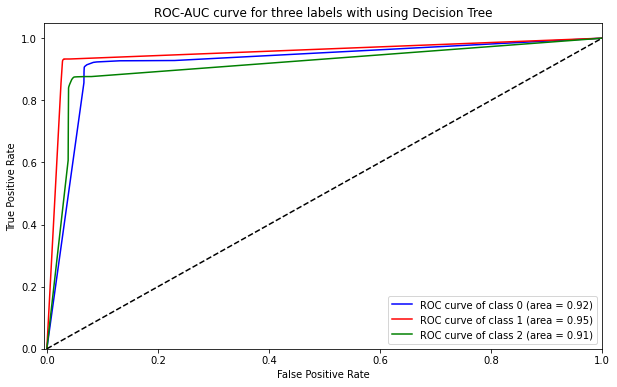

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, dt_pros[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.gcf().set_size_inches(10, 6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for three labels with using Decision Tree')
plt.legend(loc="lower right")
plt.show()

# **Random Forest**

In [ ]:
model_RF = RandomForestClassifier(random_state=0)
model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
y_predict_RF = model_RF.predict(X_test)
acc_score_RF = accuracy_score(y_test, y_predict_RF)
print("Accuracy score: {} %".format(acc_score_RF*100))
print(confusion_matrix(y_test, y_predict_RF))
bot_recall_score = recall_score(y_test, y_predict_RF, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_RF, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_RF, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 94.56612982247007 %
[[154318      5   5940]
 [   425  86473   2147]
 [  6421   2475  62249]]
Botnet traffic recall score: 0.9711157280026953
Botnet traffic precision score: 0.9721201083718368
Botnet traffic f1 score: 0.9716176586253779


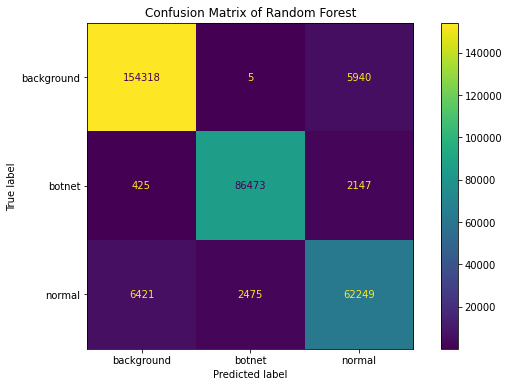

In [ ]:
matrix = plot_confusion_matrix(model_RF, X_test, y_test,  display_labels=['background','botnet','normal'], values_format='d')
matrix.ax_.set_title('Confusion Matrix of Random Forest')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
rf_pros = model_RF.predict_proba(X_test)
rf_pros

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.27749578e-01, 0.00000000e+00, 7.72250422e-01],
       [0.00000000e+00, 9.90000000e-01, 1.00000000e-02],
       ...,
       [9.67783799e-01, 0.00000000e+00, 3.22162008e-02],
       [9.99198054e-01, 0.00000000e+00, 8.01946090e-04],
       [9.80268760e-01, 0.00000000e+00, 1.97312399e-02]])

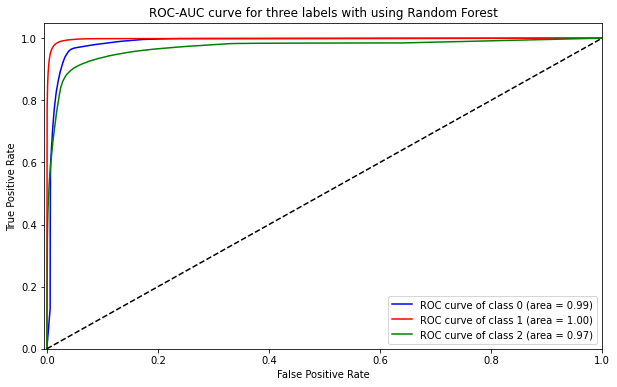

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, rf_pros[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.gcf().set_size_inches(10, 6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for three labels with using Random Forest')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save model
joblib.dump(model_RF, '/content/drive/MyDrive/Colab Notebooks/RandomForest_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/RandomForest_model.joblib']

# **Naive Bayes**

In [ ]:
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_predict_NB = model_NB.predict(X_test)
acc_score_NB = accuracy_score(y_test, y_predict_NB)
print("Accuracy score: {} %".format(acc_score_NB*100))
print(confusion_matrix(y_test, y_predict_NB))
bot_recall_score = recall_score(y_test, y_predict_NB, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_NB, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_NB, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 27.41868542344743 %
[[ 17244     12 143007]
 [  1642      5  87398]
 [   529      1  70615]]
Botnet traffic recall score: 5.6151384131618846e-05
Botnet traffic precision score: 0.2777777777777778
Botnet traffic f1 score: 0.00011228007141012543


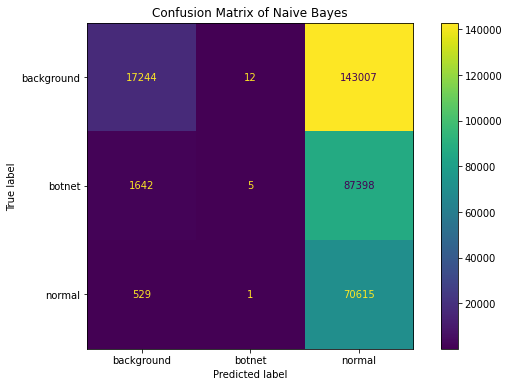

In [ ]:
matrix = plot_confusion_matrix(model_NB, X_test, y_test, display_labels=['background','botnet','normal'], values_format='d')
matrix.ax_.set_title('Confusion Matrix of Naive Bayes')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
nb_pros = model_NB.predict_proba(X_test)
nb_pros

array([[0.00297127, 0.41756015, 0.57946858],
       [0.00297121, 0.41758033, 0.57944847],
       [0.00297114, 0.41758391, 0.57944494],
       ...,
       [0.00297143, 0.41753816, 0.57949041],
       [0.00297143, 0.4175382 , 0.57949037],
       [0.00297143, 0.41753828, 0.57949029]])

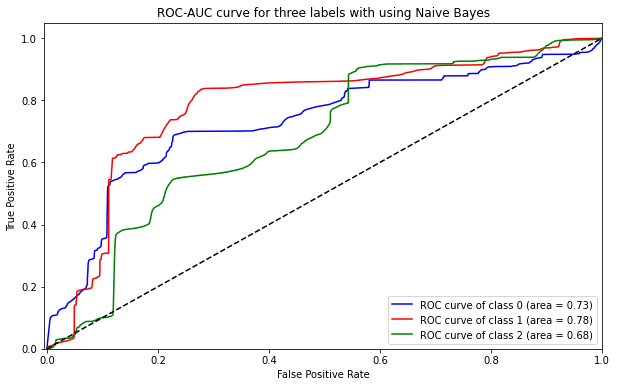

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, nb_pros[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.gcf().set_size_inches(10, 6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for three labels with using Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# **XGBoost**

In [ ]:
model_XGB = XGBClassifier(random_state=0)
model_XGB.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
y_predict_XGB = model_XGB.predict(X_test)
acc_score_XGB = accuracy_score(y_test, y_predict_XGB)
print("Accuracy score: {} %".format(acc_score_XGB*100))
print(confusion_matrix(y_test, y_predict_XGB))
bot_recall_score = recall_score(y_test, y_predict_XGB, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_XGB, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_XGB, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 84.70945817327346 %
[[147571   6370   6322]
 [ 12277  74123   2645]
 [ 17739   3646  49760]]
Botnet traffic recall score: 0.8324218091975967
Botnet traffic precision score: 0.8809588894567323
Botnet traffic f1 score: 0.8560028640059127


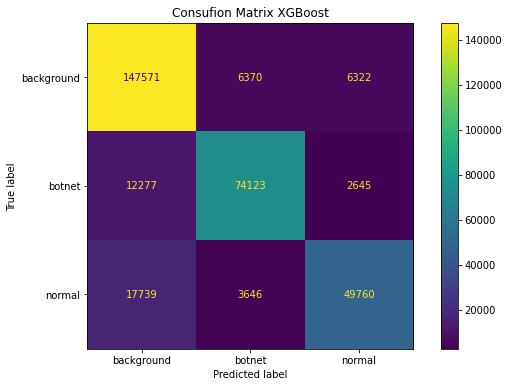

In [ ]:
matrix = plot_confusion_matrix(model_XGB, X_test, y_test, display_labels=['background','botnet','normal'], values_format='d')
matrix.ax_.set_title('Consufion Matrix XGBoost')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
xgb_pros = model_XGB.predict_proba(X_test)
xgb_pros

array([[0.9515103 , 0.02662576, 0.02186396],
       [0.36123323, 0.60549116, 0.03327566],
       [0.01158504, 0.9840343 , 0.0043807 ],
       ...,
       [0.63652176, 0.15664004, 0.20683818],
       [0.82011324, 0.07301915, 0.10686759],
       [0.9428553 , 0.01745935, 0.03968534]], dtype=float32)

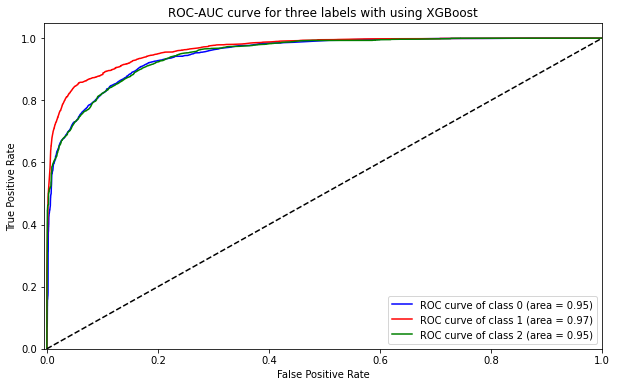

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, xgb_pros[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.gcf().set_size_inches(10, 6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for three labels with using XGBoost')
plt.legend(loc="lower right")
plt.show()

# **K-Nearest Neighbors**

In [ ]:
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_predict_KNN = model_KNN.predict(X_test)
acc_score_KNN = accuracy_score(y_test, y_predict_KNN)
print("Accuracy score: {} %".format(acc_score_KNN*100))
print(confusion_matrix(y_test, y_predict_KNN))
bot_recall_score = recall_score(y_test, y_predict_KNN, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_KNN, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_KNN, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 91.1490920665433 %
[[147211   5194   7858]
 [  3953  83790   1302]
 [  7790   2266  61089]]
Botnet traffic recall score: 0.9409848952776686
Botnet traffic precision score: 0.9182465753424658
Botnet traffic f1 score: 0.9294766909786739


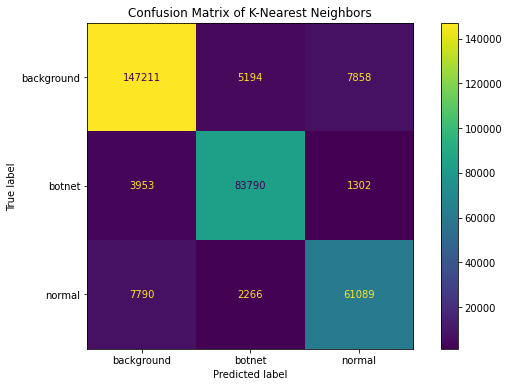

In [ ]:
matrix = plot_confusion_matrix(model_KNN, X_test, y_test, display_labels=['background','botnet','normal'], values_format='d')
matrix.ax_.set_title('Confusion Matrix of K-Nearest Neighbors')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
knn_pros = model_KNN.predict_proba(X_test)
knn_pros

array([[1. , 0. , 0. ],
       [0.8, 0. , 0.2],
       [0. , 1. , 0. ],
       ...,
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ]])

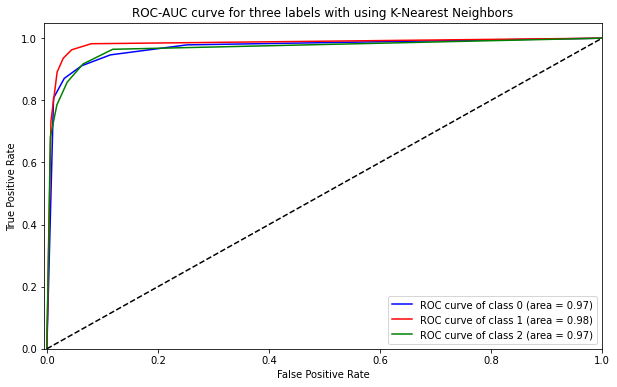

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, knn_pros[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.gcf().set_size_inches(10, 6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for three labels with using K-Nearest Neighbors')
plt.legend(loc="lower right")
plt.show()

# **Logistic Regression**

In [ ]:
model_LR = LogisticRegression(random_state=0)
model_LR.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
y_predict_LR = model_LR.predict(X_test)
acc_score_LR = accuracy_score(y_test, y_predict_LR)
print("Accuracy score: {} %".format(acc_score_LR*100))
print(confusion_matrix(y_test, y_predict_LR))
bot_recall_score = recall_score(y_test, y_predict_LR, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_LR, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_LR, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 62.5495782532852 %
[[154799   5463      1]
 [ 43402  45643      0]
 [ 70477    668      0]]
Botnet traffic recall score: 0.5125835251838958
Botnet traffic precision score: 0.8815814887781512
Botnet traffic f1 score: 0.6482505911844283


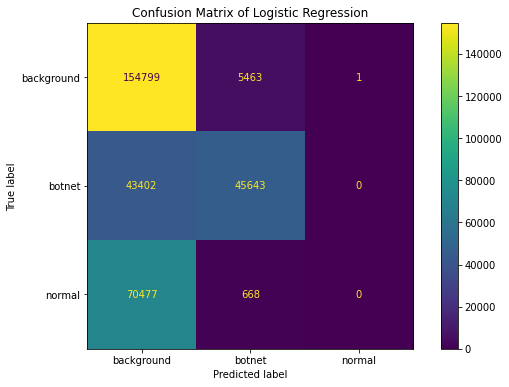

In [ ]:
matrix = plot_confusion_matrix(model_LR, X_test, y_test, display_labels=['background','botnet','normal'], values_format='d')
matrix.ax_.set_title('Confusion Matrix of Logistic Regression')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [ ]:
lr_pros = model_LR.predict_proba(X_test)
lr_pros

array([[0.85129965, 0.00301066, 0.14568969],
       [0.13671952, 0.8541587 , 0.00912179],
       [0.06787024, 0.91490113, 0.01722862],
       ...,
       [0.57998443, 0.16151166, 0.25850392],
       [0.57998309, 0.16151408, 0.25850282],
       [0.57998086, 0.16151828, 0.25850086]])

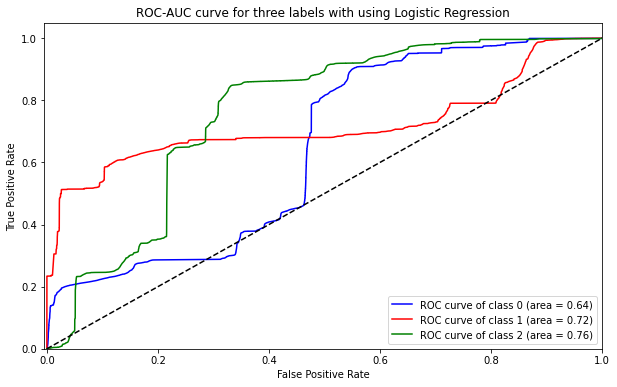

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, lr_pros[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.gcf().set_size_inches(10, 6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve for three labels with using Logistic Regression')
plt.legend(loc="lower right")
plt.show()